In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as im
import os 
import pandas as pdk
import cv2 as cv
from skimage.color import rgb2gray
import math
import random
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


`import numpy as np` : Digunakan untuk komputasi numerik dengan array dan matriks, serta menyediakan fungsi matematika tingkat tinggi untuk operasi ini.

`import matplotlib.pyplot as plt` : Digunakan untuk membuat visualisasi data seperti grafik dan plot.

`import matplotlib.image as im`: Digunakan untuk membaca dan memanipulasi gambar.

`import os`:  Digunakan untuk berinteraksi dengan sistem operasi, misalnya mengelola file dan direktori.

`import pandas` : Digunakan untuk manipulasi dan analisis data yang efisien dengan struktur data DataFrame dan Series.

`import cv2`: Digunakan untuk pemrosesan gambar dan video, termasuk fungsi untuk pengolahan citra digital.

`from skimage.color import rgb2gray` : Fungsi dari scikit-image yang digunakan untuk mengkonversi gambar RGB menjadi gambar grayscale.

`import math` : Menyediakan fungsi matematika dasar seperti trigonometri, logaritma, dll.

`import random` : Digunakan untuk menghasilkan angka acak dan melakukan berbagai operasi terkait.

`from skimage.feature import graycomatrix, graycoprops` : Digunakan untuk menghitung matriks co-occurrence tingkat abu-abu (GLCM) yang digunakan untuk menganalisis tekstur dan digunakan untuk menghitung sifat-sifat tekstur dari GLCM, seperti kontras, homogenitas, dan korelasi.

`from sklearn.model_selection import train_test_split` : Fungsi dari scikit-learn untuk membagi dataset menjadi set pelatihan dan pengujian.

`import seaborn as sns` :  Digunakan untuk membuat visualisasi statistik yang informatif dan menarik.

`from sklearn.decomposition import PCA` : Digunakan untuk reduksi dimensi data dengan cara mengubah data ke dalam komponen utama yang lebih sedikit tetapi tetap mempertahankan variasi data sebanyak mungkin.

`from sklearn.preprocessing import StandardScaler` : Digunakan untuk standarisasi fitur dengan menghapus rata-rata dan menskalakan ke varians unit.

`from sklearn.metrics import confusion_matrix` : Digunakan untuk menghitung matriks kebingungan yang memberikan gambaran tentang kinerja model klasifikasi.

`from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score` : Fungsi accuracy_score digunakan untuk menghitung akurasi klasifikasi, sedangkan precision_score digunakan untuk menghitung presisi klasifikasi. Fungsi recall_score menghitung recall atau sensitivitas klasifikasi, dan f1_score digunakan untuk menghitung skor F1 yang merupakan rata-rata harmonis dari presisi dan recall. 

`from sklearn.neighbors import KNeighborsClassifier` : Algoritma k-Nearest Neighbors (k-NN) untuk klasifikasi data.

`from sklearn.ensemble import RandomForestClassifier`: Algoritma ensemble yang menggunakan banyak pohon keputusan untuk klasifikasi data.

`from sklearn.svm import SVC` Algoritma Support Vector Machine untuk klasifikasi data.

`from sklearn.discriminant_analysis import LinearDiscriminantAnalysis` : Algoritma untuk analisis diskriminan linear, digunakan untuk klasifikasi dan pengurangan dimensi.


# Data Loading

In [2]:
folder = [
    "dataset/busuk/",
    "dataset/segar/",
    "dataset/setengah segar/"
]
data = []
labels = []
fileName = []
for i in folder:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        data.append(temp)
        labels.append(label)
        fileName.append(nama)

Kode tersebut membaca gambar dari tiga folder berbeda dalam direktori "dataset" yang masing-masing berisi gambar daging busuk, segar, dan setengah segar. Untuk setiap gambar, kode akan menambahkan gambar tersebut ke dalam daftar data, menambahkan label yang sesuai (busuk, segar, atau setengah segar) ke dalam daftar labels, dan menambahkan nama file gambar tanpa ekstensi ke dalam daftar fileName. Jika ada gambar yang tidak dapat dimuat, pesan error akan dicetak dan gambar tersebut diabaikan. Label diubah menjadi huruf kecil dan spasi diganti dengan garis bawah.

Kemudian menampilkan sampel gambar dari setiap kategori label dalam dataset dalam fungsi `plot_samples`. Fungsi ini pertama-tama menemukan label unik dalam data, lalu membuat subplot dengan ukuran yang sesuai untuk menampilkan num_samples gambar dari setiap label. Untuk setiap label, fungsi memilih secara acak beberapa gambar, kemudian menampilkan gambar-gambar tersebut dalam subplot. Gambar grayscale ditampilkan dengan colormap 'gray', sementara gambar berwarna ditampilkan dengan konversi warna BGR ke RGB. Setiap gambar ditampilkan tanpa sumbu, dan subplot pertama dari setiap baris diberi judul sesuai dengan labelnya.

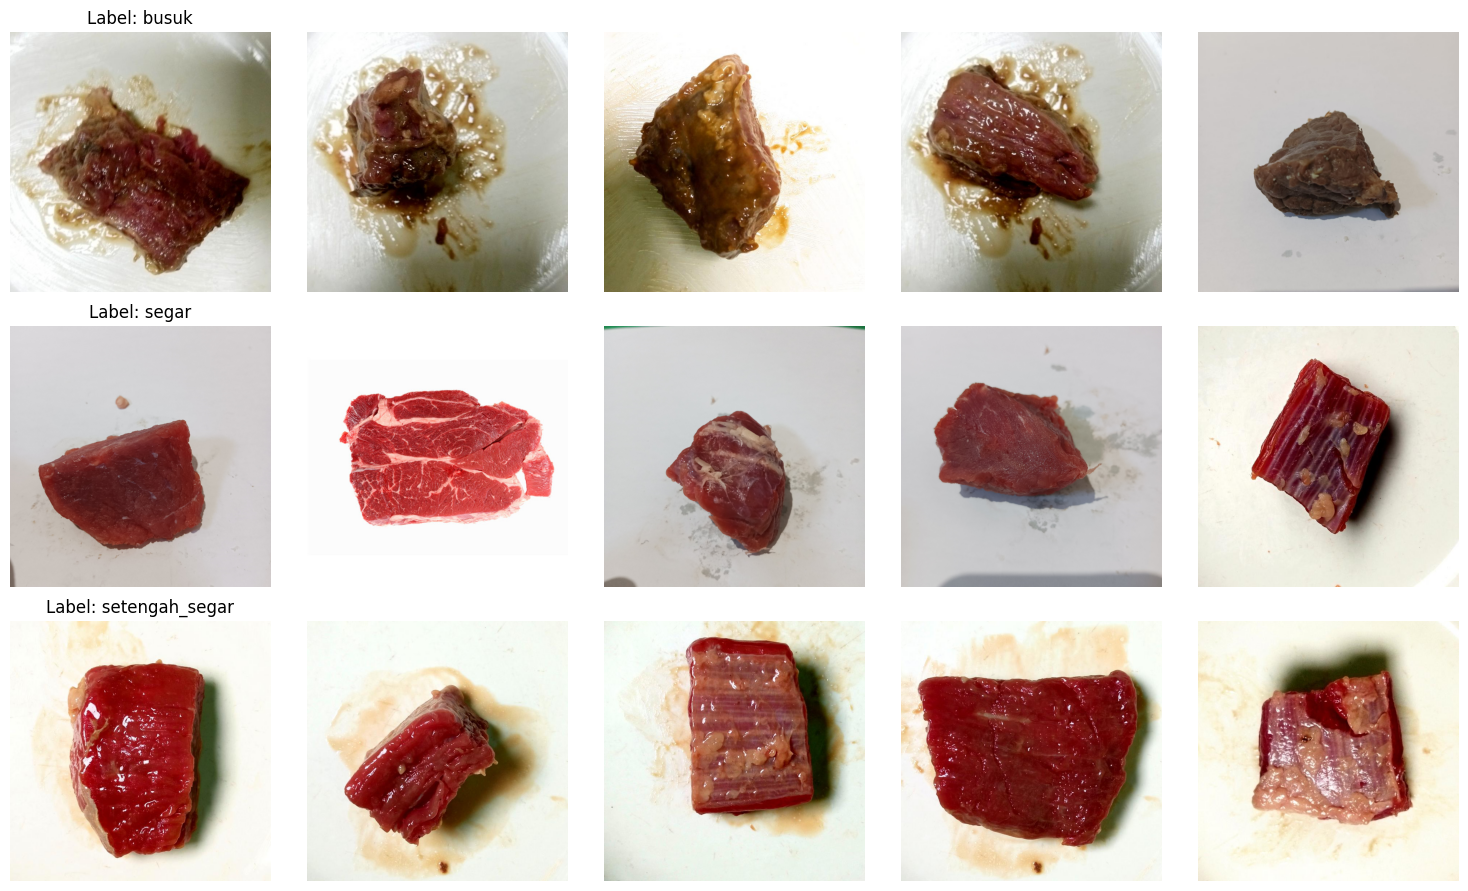

In [3]:
def plot_samples(data, label, num_samples=5):
    unique_labels = np.unique(label)
    fig, axes = plt.subplots(len(unique_labels), num_samples, figsize=(num_samples*3, len(unique_labels)*3))
    for i, j in enumerate(unique_labels):
        indices = [idx for idx, l in enumerate(label) if l == j]
        sample_indices = random.sample(indices, num_samples)
        for k, sample_idx in enumerate(sample_indices):
            if data[sample_idx].ndim == 2: 
                axes[i, k].imshow(data[sample_idx], cmap='gray')
            elif data[sample_idx].shape[2] == 3:
                image = data[sample_idx][:, :, ::-1]
                axes[i, k].imshow(image)
            axes[i, k].axis('off')
            if k == 0:
                axes[i, k].set_title(f'Label: {j}')

    plt.tight_layout()
    plt.show()

plot_samples(data, labels)

# Data prepation

Data preparation adalah proses mengumpulkan, membersihkan, dan mengorganisir data mentah agar siap digunakan dalam analisis atau pemodelan lebih lanjut. 

In [4]:
data = []
labels = []
fileName = []
for i in folder:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        grayimage = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
        data.append(grayimage)
        labels.append(label)
        fileName.append(nama)

Kode ini mirip dengan kode sebelumnya pada data loading, namun ada sedikit perbedaan penting seperti setelah memuat gambar, gambar tersebut dikonversi menjadi grayscale menggunakan cv.cvtColor dengan parameter cv.COLOR_BGR2GRAY. Ini berarti bahwa setiap gambar dalam dataset diubah menjadi gambar grayscale sebelum ditambahkan ke daftar data.

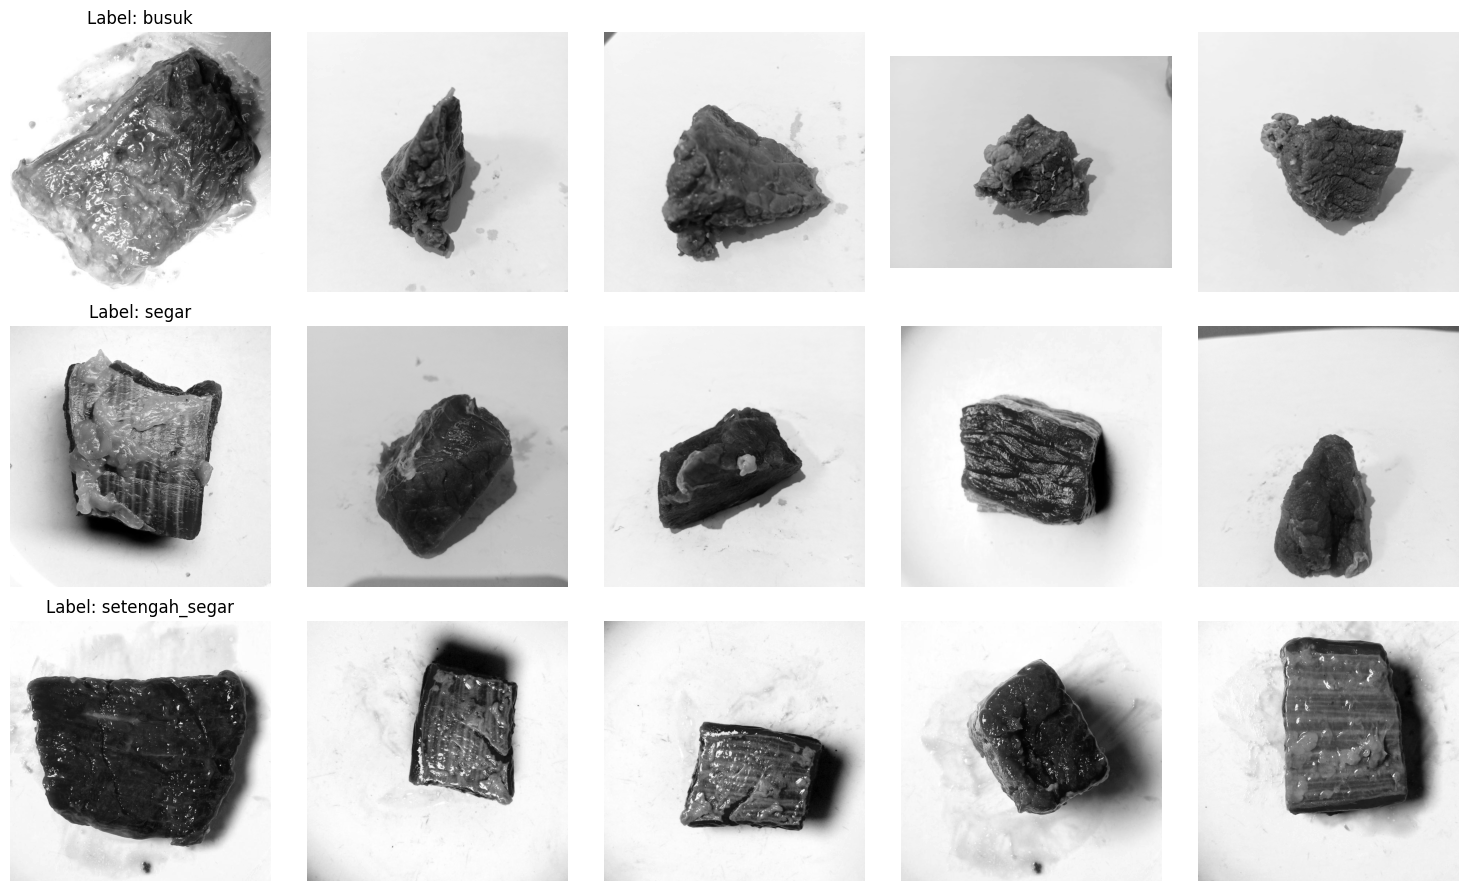

In [5]:
def plot_samples(data, label, num_samples=5):
    unique_labels = np.unique(label)
    fig, axes = plt.subplots(len(unique_labels), num_samples, figsize=(num_samples*3, len(unique_labels)*3))
    for i, j in enumerate(unique_labels):
        indices = [idx for idx, l in enumerate(label) if l == j]
        sample_indices = random.sample(indices, num_samples)
        for k, sample_idx in enumerate(sample_indices):
            if data[sample_idx].ndim == 2: 
                axes[i, k].imshow(data[sample_idx], cmap='gray')
            elif data[sample_idx].shape[2] == 3:
                image = data[sample_idx][:, :, ::-1]
                axes[i, k].imshow(image)
            axes[i, k].axis('off')
            if k == 0:
                axes[i, k].set_title(f'Label: {j}')

    plt.tight_layout()
    plt.show()

plot_samples(data, labels)

In [6]:
def padding (image, kernel):
    if len(kernel)% 2 == 0:
        n = int(len(kernel)/2)
        output = np.pad(image, ([0,n], [0,n]))
    else:
        n = int((len(kernel)-1)/2)
        output = np.pad(image, ([n,n], [n,n]))
    return output

def konvolusi(pad, image, kernel):
    output = np.zeros(image.shape).astype(int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(len(kernel)):
                for l in range(len(kernel)):
                    output[i,j] += pad[i+k, j+l] * kernel[k][l]
    return output

def edge_detection(image, kernel1, kernel2):
    pad_image = padding(image, kernel1)
    konv1 = konvolusi(pad_image, image, kernel1)
    konv2 = konvolusi(pad_image, image, kernel2)

    square1 = konv1 * konv1
    square2 = konv2 * konv2

    gy = np.zeros(square1.shape).astype(int)
    gy = np.sqrt(square1)

    gx = np.zeros(square2.shape).astype(int)
    gx = np.sqrt(square2)

    hasil_sum = square1 + square2
    output = np.sqrt(hasil_sum)

    return output, gx, gy

- Fungsi padding digunakan untuk menambahkan padding pada citra input berdasarkan ukuran kernel yang digunakan. Jika ukuran kernel genap, maka padding akan ditambahkan setengah dari ukuran kernel ke setiap sisi citra. Jika ukuran kernel ganjil, padding akan ditambahkan setengah dari ukuran kernel dikurangi satu ke setiap sisi citra.

- Fungsi konvolusi melakukan proses konvolusi antara citra yang telah dipadding dengan kernel yang diberikan. Proses konvolusi dilakukan dengan mengalikan nilai piksel dengan nilai kernel yang sesuai pada area yang bersesuaian, kemudian menjumlahkan hasilnya.

- Fungsi edge_detection menggunakan fungsi padding dan konvolusi untuk mendeteksi tepi pada citra. Pertama, citra dipadding dengan kernel pertama, lalu dilakukan konvolusi dengan kernel tersebut. Proses yang sama dilakukan dengan kernel kedua. Selanjutnya, dilakukan operasi untuk menghitung gradien vertikal dan horizontal (gy dan gx) dari kedua hasil konvolusi. Hasil akhir dari deteksi tepi adalah akar kuadrat dari penjumlahan kuadrat hasil konvolusi menggunakan kedua kernel.

In [7]:
sx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])

sy = np.array([[1, 2, 1],
               [0, 0, 0],
               [-1, -2, -1]])

kernel yang dibutuhkan untuk operasi deteksi tepi sobel

In [8]:
def preprocess(image):
    resized_image = cv.resize(image, (500, 500))
    edge_detected, _, _ = edge_detection(resized_image, sx, sy)
    
    return edge_detected

Fungsi preprocess(image) ini digunakan untuk memproses gambar yang diberikan. Pertama, gambar diubah ukurannya menjadi 500x500 piksel menggunakan fungsi cv.resize. Selanjutnya, gambar yang sudah diresize tersebut diproses untuk mendeteksi tepi menggunakan fungsi edge_detection. Hasil dari deteksi tepi disimpan dalam variabel edge_detected. Fungsi kemudian mengembalikan gambar yang telah melalui proses resize dan deteksi tepi sebagai outputnya. 

In [9]:
preprocessed_path = 'dataset/preprocess/'
categories = ['busuk', 'segar', 'setengah_segar']

if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)

for category in categories:
    category_path = os.path.join(preprocessed_path, category)
    if not os.path.exists(category_path):
        os.makedirs(category_path)

Kode digunakan untuk membuat struktur direktori untuk menyimpan dataset yang telah diproses sebelumnya. Pertama, variabel 'preprocessed_path' diatur ke 'dataset/preprocess/', dan daftar 'categories' berisi tiga kategori: 'busuk', 'segar', dan 'setengah_segar'. Kode kemudian memeriksa apakah direktori utama 'preprocessed_path' sudah ada, dan membuatnya jika belum. Selanjutnya, untuk setiap kategori dalam daftar, kode membuat subdirektori di dalam 'preprocessed_path'. Ini memastikan bahwa ada tempat yang terorganisir untuk menyimpan data yang telah diproses untuk masing-masing kategori.

In [10]:
preprocess_data = []
preprocess_labels = []
preprocess_file_names = []

counter = {'busuk': 1, 'segar': 1, 'setengah_segar': 1}

for i, image in enumerate(data):
    label = labels[i]
    name = fileName[i]
    prepro_image = preprocess(image)
    
    if label not in counter:
        print(f"Label {label} tidak ditemukan dalam counter dictionary.")
        continue

    label_folder = label.lower()
    save_name = f"{label_folder}_{counter[label_folder]}.jpg"
    save_path = os.path.join(preprocessed_path, label_folder, save_name)
    cv.imwrite(save_path, prepro_image)
    preprocess_data.append(prepro_image)
    preprocess_labels.append(label)
    preprocess_file_names.append(save_name)
    counter[label_folder] += 1

Kode diatas melakukan preprocessing pada dataset gambar. Pertama, ia menginisialisasi list kosong untuk menyimpan data yang telah diproses, label, dan nama file. Sebuah dictionary 'counter' dibuat untuk menghitung jumlah gambar dalam setiap kategori. Selanjutnya, kode melakukan iterasi melalui setiap gambar dalam dataset, memproses gambar tersebut, dan menyimpannya dengan nama baru di folder yang sesuai. Nama file baru dibuat menggunakan label dan nomor urut. Gambar yang telah diproses, labelnya, dan nama file barunya ditambahkan ke list yang sesuai. Counter untuk kategori tersebut kemudian ditingkatkan. Jika ditemukan label yang tidak ada dalam dictionary counter, pesan kesalahan akan dicetak dan iterasi akan dilanjutkan ke gambar berikutnya.

Kode dibawah digunakan untuk menampilkan gambar yang telah diproses sebelumnya. Ia membuat sebuah figure berukuran 15x5 inci dan menampilkan maksimal 12 gambar dalam grid 2x6. Setiap gambar ditampilkan dalam subplot terpisah menggunakan colormap grayscale, dengan menonaktifkan sumbu pada gambar. 

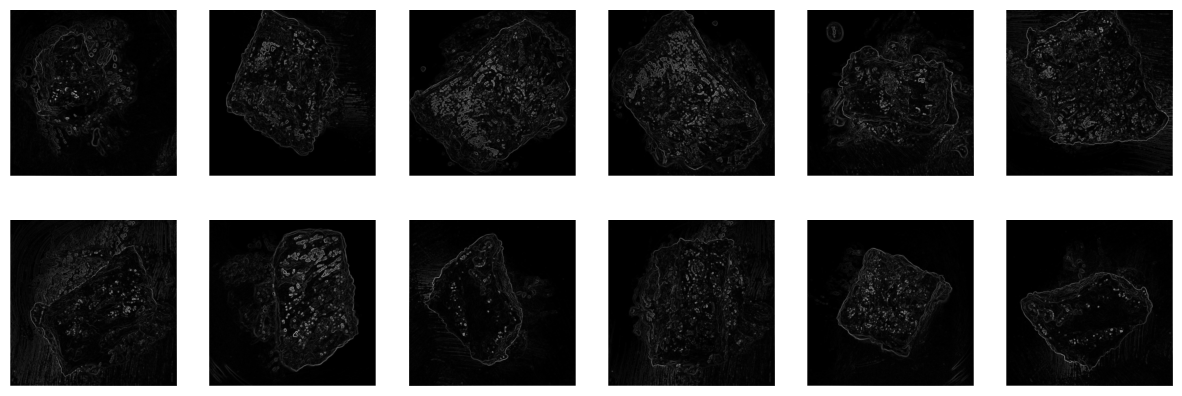

In [11]:
plt.figure(figsize=(15, 5))
for i in range(min(12, len(preprocess_data))):
    plt.subplot(2, 6, i+1)
    plt.imshow(preprocess_data[i], cmap='gray')
    plt.axis('off')
plt.show()

In [12]:
jenis = {
    'busuk' :0,
    'segar' :1,
    'setengah_segar' :2
}

variabel 'jenis' digunakan untuk memetakan tiga kategori daging ke nilai numerik. 'busuk' diberi nilai 0, 'segar' diberi nilai 1, dan 'setengah_segar' diberi nilai 2. Pemetaan ini berguna untuk mengubah label kategorikal menjadi representasi numerik, yang sering diperlukan dalam pemrosesan data dan pembelajaran mesin.

In [13]:
def extract_glcm_features(images, labels, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    angle_labels = ['0', '45', '90', '135']
    df_data = pd.DataFrame()
    
    for i, image in enumerate(images):
        # Ensure image is in integer format
        image = image.astype(int)
        
        # Check the maximum pixel intensity
        image_max = image.max()
        if image_max >= levels:
            # If maximum intensity exceeds levels, rescale image values
            image = image * (levels - 1) // image_max
        
        # Calculate GLCM
        glcm = graycomatrix(image, distances, angles, levels=levels, symmetric=symmetric, normed=normed)
        
        # Extract features from GLCM
        for feature in features:
            for angle, angle_label in zip(angles, angle_labels):
                feat_a = graycoprops(glcm, feature)[0, int(angle * 4 / np.pi)]
                df_data.loc[i, f'{feature}_{angle_label}'] = feat_a
        
        # Calculate additional GLCM properties
        for angle, angle_label in zip(angles, angle_labels):
            asm = np.sum(glcm[:, :, 0, int(angle * 4 / np.pi)] ** 2)
            entropy = -np.sum(glcm[:, :, 0, int(angle * 4 / np.pi)] * np.log2(glcm[:, :, 0, int(angle * 4 / np.pi)] + np.finfo(float).eps))
            df_data.loc[i, f'asm_{angle_label}'] = asm
            df_data.loc[i, f'entropy_{angle_label}'] = entropy
        
        df_data.loc[i, 'label'] = jenis[labels[i]] 
        
    return df_data

Fungsi extract_glcm_features digunakan untuk mengekstrak fitur GLCM (Gray Level Co-occurrence Matrix) dari serangkaian gambar. Untuk setiap gambar, fungsi menghitung GLCM dengan parameter jarak, sudut, dan level yang ditentukan. Kemudian, ia mengekstrak berbagai fitur statistik seperti kontras, disimilaritas, homogenitas, energi, dan korelasi untuk setiap sudut. Fungsi juga menghitung ASM (Angular Second Moment) dan entropi. Semua fitur ini disimpan dalam DataFrame pandas, dengan setiap baris mewakili satu gambar dan kolom-kolom mewakili fitur yang berbeda. Label gambar juga ditambahkan ke DataFrame, dikonversi ke nilai numerik menggunakan dictionary 'jenis'. 

In [14]:
folder_baru = [
    "dataset/preprocess/busuk/",
    "dataset/preprocess/segar/",
    "dataset/preprocess/setengah_segar/"
]
data = []
labels = []
fileName = []
for i in folder:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        grayimage = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
        data.append(grayimage)
        labels.append(label)
        fileName.append(nama)

Kode diatas membaca dan memproses gambar dari tiga folder yang berbeda, masing-masing mewakili kategori daging yang berbeda (busuk, segar, setengah segar). Untuk setiap folder, kode mengekstrak label dari nama folder, kemudian iterasi melalui semua file di dalamnya. Setiap gambar dibaca menggunakan OpenCV, dikonversi ke grayscale, dan ditambahkan ke list 'data'. Label yang sesuai ditambahkan ke list 'labels', dan nama file (tanpa ekstensi) ditambahkan ke list 'fileName'. Jika ada gambar yang tidak dapat dimuat, pesan kesalahan dicetak dan iterasi dilanjutkan ke file berikutnya. Proses ini menghasilkan tiga list paralel yang berisi data gambar grayscale, label kategori, dan nama file

In [15]:
df_glcm = extract_glcm_features(preprocess_data, preprocess_labels)

Kode di atas memanggil fungsi extract_glcm_features pada data yang telah diproses sebelumnya. Fungsi ini mengambil dua argumen: preprocess_data yang berisi gambar-gambar yang telah diproses, dan preprocess_labels yang berisi label-label yang sesuai. Fungsi kemudian menghitung fitur-fitur GLCM (Gray Level Co-occurrence Matrix) untuk setiap gambar, termasuk kontras, disimilaritas, homogenitas, energi, korelasi, ASM, dan entropi, pada berbagai sudut. Hasilnya disimpan dalam sebuah DataFrame pandas bernama df_glcm, 

menampilkan df_glcm

In [16]:
df_glcm

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,label
0,365.432125,511.875833,316.440246,511.402543,7.223051,8.035733,6.937572,8.025763,0.311669,0.304722,...,0.163003,0.013135,8.443120,0.012828,8.467418,0.013307,8.428736,0.012917,8.467340,0.0
1,469.369709,668.137995,478.376695,669.531380,8.585426,9.625809,8.604202,9.682980,0.462582,0.453120,...,0.189173,0.119238,7.551135,0.117112,7.595443,0.118853,7.562965,0.116933,7.598892,0.0
2,639.248073,864.086194,664.421786,828.327971,12.059596,13.283417,12.209721,12.774714,0.345042,0.333199,...,0.233912,0.058438,8.981913,0.055427,9.044391,0.056653,9.011876,0.056122,9.014523,0.0
3,664.147689,827.883459,638.705204,863.691512,12.209362,12.770556,12.057689,13.287050,0.340197,0.339201,...,0.201462,0.056704,9.010963,0.056179,9.013335,0.058484,8.981078,0.055340,9.045834,0.0
4,494.703758,676.209767,461.776651,677.780283,9.480008,10.538176,9.390453,10.543420,0.351425,0.343413,...,0.167123,0.047270,8.612215,0.045492,8.653772,0.047225,8.616035,0.045873,8.652087,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,456.132097,682.127821,422.650881,671.283620,7.342554,8.541339,6.952424,8.423383,0.348220,0.341782,...,0.149492,0.017785,8.106629,0.017301,8.134734,0.018454,8.048074,0.017294,8.132006,2.0
137,460.627572,693.750785,442.789422,666.102258,6.278190,7.317227,6.074238,6.919367,0.504071,0.491761,...,0.209162,0.083767,6.565927,0.080741,6.599233,0.084277,6.538530,0.081187,6.565073,2.0
138,379.575867,651.997655,424.016222,652.499260,5.828279,7.280205,6.339891,7.315427,0.363086,0.354472,...,0.137879,0.020386,7.526151,0.019858,7.581132,0.020263,7.568297,0.019903,7.585101,2.0
139,477.232299,702.205649,416.266234,691.429740,6.614642,7.728314,5.925289,7.614704,0.531363,0.521717,...,0.176519,0.117449,6.408252,0.114511,6.442327,0.119204,6.354451,0.114677,6.437238,2.0


In [17]:
df_glcm.to_csv('glcm_features_small.csv', index=False)
df_glcm = pd.read_csv('glcm_features_small.csv')

Kode diatas melakukan dua operasi pada DataFrame df_glcm. Pertama, df_glcm.to_csv('glcm_features_small.csv', index=False) menyimpan DataFrame ke file CSV bernama 'glcm_features_small.csv', tanpa menyertakan indeks baris. Ini berguna untuk menyimpan hasil ekstraksi fitur GLCM secara permanen. Kemudian, df_glcm = pd.read_csv('glcm_features_small.csv') membaca kembali file CSV yang baru saja disimpan ke dalam DataFrame df_glcm. Proses ini memastikan bahwa data dapat diakses kembali dalam sesi kerja berikutnya tanpa perlu mengekstrak ulang fitur GLCM, yang bisa jadi merupakan proses yang memakan waktu.

Kode dibawah membuat visualisasi korelasi antara fitur-fitur GLCM dalam bentuk heatmap. Pertama, corr_glcm = df_glcm.corr() menghitung matriks korelasi dari DataFrame df_glcm. Kemudian, sebuah figure berukuran 15x15 inci dibuat menggunakan matplotlib. Fungsi sns.heatmap() dari seaborn digunakan untuk menggambar heatmap, dengan parameter annot=True untuk menampilkan nilai korelasi di setiap sel, cmap='coolwarm' untuk skema warna, dan cbar=False untuk menghilangkan color bar. Ukuran label pada kedua sumbu diatur menjadi 8. 

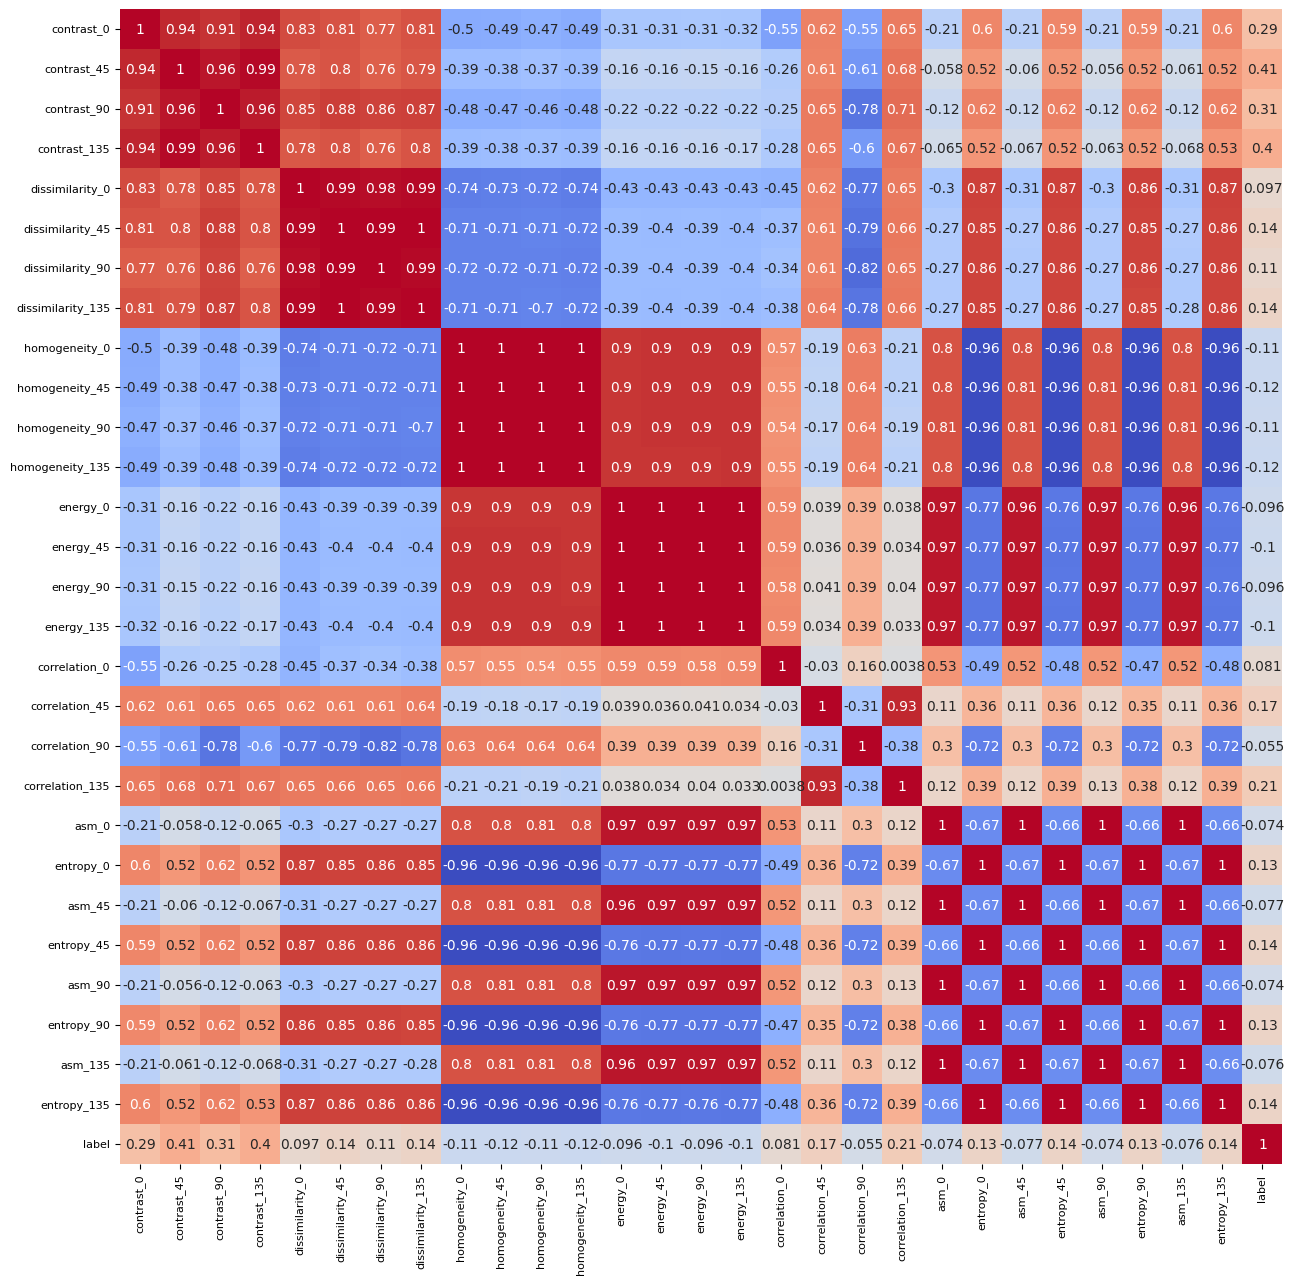

In [18]:
corr_glcm = df_glcm.corr()  
plt.figure(figsize=(15,15))
sns.heatmap(corr_glcm, annot=True, cmap='coolwarm', cbar=False)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.show()

In [19]:
x, y = df_glcm.drop('label', axis=1), df_glcm['label']
pca = PCA(n_components=25)
x_pca = pca.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((112, 25), (29, 25), (112,), (29,))

Kode diatas digunakan untuk melakukan persiapan data untuk pelatihan model machine learning. Pertama, fitur (X) dan label (y) dipisahkan dari DataFrame df_glcm. Kemudian, PCA (Principal Component Analysis) diterapkan untuk mereduksi dimensi fitur menjadi 25 komponen utama. Data yang sudah direduksi dimensinya kemudian dibagi menjadi set pelatihan dan pengujian menggunakan train_test_split, dengan 80% data untuk pelatihan dan 20% untuk pengujian. Pembagian ini dilakukan dengan random_state=42 untuk memastikan hasil yang dapat direproduksi. Akhirnya, bentuk (shape) dari set data pelatihan dan pengujian ditampilkan, memberikan informasi tentang jumlah sampel dan fitur dalam setiap set

In [20]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


Kode diatas melakukan standardisasi data menggunakan StandardScaler dari scikit-learn. Pertama, sebuah objek StandardScaler dibuat. Kemudian, metode fit_transform digunakan pada data pelatihan (x_train), yang menghitung mean dan standar deviasi dari setiap fitur, lalu mentransformasi data sehingga setiap fitur memiliki mean 0 dan standar deviasi 1. Untuk data pengujian (x_test), hanya metode transform yang digunakan, yang menerapkan scaling yang sama dengan data pelatihan tanpa menghitung ulang statistiknya. 

In [21]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8275862068965517


Kode diatas menerapkan dan mengevaluasi model K-Nearest Neighbors (KNN) untuk klasifikasi. Sebuah classifier KNN dibuat dengan parameter n_neighbors=1 (menggunakan tetangga terdekat) dan metric='cosine' (menggunakan jarak kosinus). Model ini kemudian dilatih menggunakan data pelatihan (x_train dan y_train). Setelah pelatihan, model digunakan untuk memprediksi label pada data pengujian (x_test). Akhirnya, akurasi model dihitung dengan membandingkan prediksi (y_pred) dengan label sebenarnya (y_test) menggunakan fungsi accuracy_score. 

In [22]:
svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8620689655172413


Kode diatas menerapkan dan mengevaluasi model Support Vector Machine (SVM) untuk klasifikasi. Sebuah classifier SVM dibuat dengan kernel 'rbf' (Radial Basis Function), parameter C=30 (mengontrol trade-off antara margin yang smooth dan klasifikasi yang tepat), dan gamma='auto' (menentukan koefisien kernel secara otomatis). Model ini dilatih menggunakan data pelatihan (x_train dan y_train). Setelah pelatihan, model digunakan untuk memprediksi label pada data pengujian (x_test). Akhirnya, akurasi model dihitung dengan membandingkan prediksi (y_pred) dengan label sebenarnya (y_test) menggunakan fungsi accuracy_score.

In [23]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6896551724137931


Kode diatas menerapkan dan mengevaluasi model Random Forest Classifier untuk klasifikasi. Sebuah classifier Random Forest dibuat dengan beberapa parameter: 500 pohon keputusan, bobot kelas yang seimbang, menggunakan semua core CPU yang tersedia, kedalaman maksimum pohon 50, minimal 1 sampel per daun, minimal 2 sampel untuk split, tanpa bootstrap, dan menggunakan kriteria Gini untuk pemisahan. Model ini dilatih menggunakan data pelatihan (x_train dan y_train). Setelah pelatihan, model digunakan untuk memprediksi label pada data pengujian (x_test). Akhirnya, akurasi model dihitung dengan membandingkan prediksi (y_pred) dengan label sebenarnya (y_test) menggunakan fungsi accuracy_score.

In [24]:
model_dict = {
    'KNN': knn,
    'SVM': svm,
    'RF': rfc
}
df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())


dictionary  model_dict dibuat, menyimpan ketiga model dengan kunci yang sesuai ('KNN', 'SVM', 'RF').
Kemudian, sebuah DataFrame pandas kosong bernama df_eval dibuat. DataFrame ini akan digunakan untuk menyimpan metrik evaluasi untuk setiap model. Kolom-kolomnya adalah 'Accuracy', 'Precision', 'Recall', dan 'F1 Score', yang merupakan metrik umum untuk evaluasi performa model klasifikasi. Indeks DataFrame ini diatur sebagai kunci dari model_dict, sehingga setiap baris akan mewakili satu model.

Kode dibawah mengevaluasi performa tiga model machine learning (KNN, SVM, dan Random Forest) pada data uji. Untuk setiap model, kode menghitung dan menyimpan akurasi, presisi, recall, dan skor F1 dalam DataFrame df_eval. Semua metrik dihitung menggunakan rata-rata tertimbang untuk menangani kemungkinan ketidakseimbangan kelas. 

In [25]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    
df_eval

,Accuracy,Precision,Recall,F1 Score
KNN,0.827586,0.854111,0.827586,0.830984
SVM,0.862069,0.883005,0.862069,0.862397
RF,0.689655,0.722323,0.689655,0.671921


Kode dibawah untuk membuat visualisasi matriks kebingungan (confusion matrix) untuk membandingkan kinerja beberapa model klasifikasi menggunakan pustaka Matplotlib dan Seaborn. Pertama, sebuah figure dan tiga subplot dibuat dengan ukuran 20x5. Kemudian, untuk setiap model dalam `model_dict`, prediksi dilakukan pada data pengujian (`x_test`), dan matriks kebingungan dihitung berdasarkan label sebenarnya (`y_test`) dan prediksi (`y_pred`). Matriks kebingungan ini divisualisasikan sebagai heatmap dengan anotasi angka menggunakan Seaborn pada masing-masing subplot. Label sumbu x dan y diatur untuk menunjukkan kelas prediksi dan kelas sebenarnya, dan setiap subplot diberi judul sesuai dengan nama model yang sedang dievaluasi. Terakhir, plot keseluruhan ditampilkan menggunakan `plt.show()`.

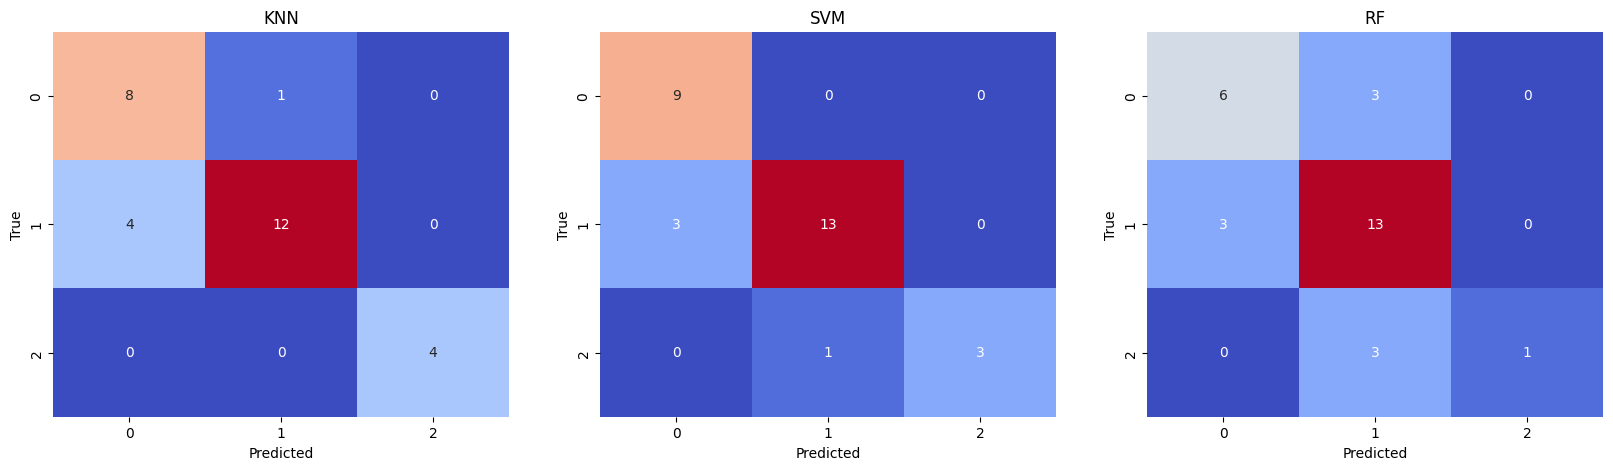

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, model_name in enumerate(model_dict.keys()):
    y_pred = model_dict[model_name].predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(model_name)
plt.show()